<a href="https://colab.research.google.com/github/shreyanshxt/brain-tumor-/blob/main/BRAIN_TUMOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.32.2
    Uninstalling huggingface-hub-0.32.2:
      Successfully uninstalled huggingface-hub-0.32.2


In [2]:
!huggingface-cli download FLARE-MedFM/FLARE-Task3-DomainAdaption --repo-type dataset --local-dir ./FLARE-MedFM/FLARE-Task3-DomainAdaption --local-dir-use-symlinks False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 8443 files:   0% 0/8443 [00:00<?, ?it/s]Downloading 'README.md' to 'FLARE-MedFM/FLARE-Task3-DomainAdaption/.cache/huggingface/download/Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.55c1904ada38ec7555d90b010737abe5ef218043.incomplete'
Fetching 8443 files:   0% 0/8443 [00:00<?, ?it/s]
README.md: 100% 4.08k/4.08k [00:00<00:00, 46.4MB/s]
Download complete. Moving file to FLARE-MedFM/FLARE-Task3-DomainAdaption/README.md
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_http.py", line 409, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 401 Client Er

In [ ]:
!pip install nibabel


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:00


In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 106.2 MB/s eta 0:00:00


In [ ]:
####Stack or Train]   → [SUV, CBF] as input to your ViT


In [ ]:
!pip install antspyx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
#aligning the two suv and cbf
import nibabel as nib
import ants
import os
from os import path
import numpy as np
#loop to go through all teh files
suv_img_path="/content/sub-patient19_SUV_z.nii"
cbf_img_path="/content/sub-patient19_cbf.nii"


base, ext = os.path.splitext(suv_img_path)
cbf_img=ants.image_read(cbf_img_path)
suv_img=ants.image_read(suv_img_path)
suv_nii=nib.load(suv_img_path)
cbf_nii=nib.load(cbf_img_path)

img_cor_suv = ants.n4_bias_field_correction(suv_img)

img_cor_cbf = ants.n4_bias_field_correction(cbf_img)
# spacing
def spacing(affine):
  affine_data= affine.affine.astype(np.float64)
  return tuple(np.sqrt((affine_data[:3, :3] ** 2).sum(axis=0)))

#min max normalization
def minmax(img_ants):
  data=img_ants.numpy()
  normalized=(data-data.min())/(data.max()-data.min() + 1e-8)
  normalized = np.nan_to_num(normalized, nan=0.0, posinf=0.0, neginf=0.0)
  affine=ants_affine(img_ants)
  new_img = nib.Nifti1Image(
        normalized,
        affine
    )
  return new_img # Return the new nibabel image

# define affine matrix
def ants_affine (img_ants):
  spacing=np.array(img_ants.spacing)
  direction=np.array(img_ants.direction)
  origin=np.array(img_ants.origin)
  affine=np.eye(4)
  for i in range(3):
    affine[i,:3]=direction[i]*spacing[i]

  affine[:3,3]=origin
  return affine


norm_suv=minmax(img_cor_suv)
norm_cbf=minmax(img_cor_cbf)

#covert npy->ants
ants_suv=ants.from_numpy(norm_suv.get_fdata())
ants_cbf=ants.from_numpy(norm_cbf.get_fdata())

#registration
reg=ants.registration(fixed=ants_suv,moving=ants_cbf,type_of_transform='SyN')
aligned_suv=reg['warpedmovout']
suv_reg=base+'_registered_'+ext
ants.image_write(aligned_suv,suv_reg)

In [ ]:
!pip install scikit-learn


In [ ]:
#image padding
def ants_img_pad(ants_img):
  data=ants_img.numpy()
  spacing = ants_img.spacing
  origin=ants_img.origin
  direction=ants_img.direction

  x,y,z =data.shape
  pad_x=max(0,256-x)
  pad_y=max(0,256-y)
  pad_z=max(0,256-z)

  pad_width=(
      (pad_x//2,pad_x-pad_x//2),
      (pad_y//2,pad_y-pad_y//2),
      (pad_z//2,pad_z-pad_z//2),
  )
  padded_data=np.pad(data,pad_width,mode='constant',constant_values=0)
  padded_img =ants.from_numpy(
      padded_data,
      spacing=spacing,
      origin=origin,
      direction=direction
  )
  return padded_img


In [ ]:
img = ants.image_read('/content/sub-patient19_SUV_z_registered_.nii')
padded_img1 = ants_img_pad(img)
padded_img_path1=os.path.splitext('/content/sub-patient19_SUV_z_registered_.nii')[0]+"_padded_"+os.path.splitext("/content/sub-patient19_SUV_z_registered_.nii")[1]
nib.save(padded_img1, padded_img_path1)
img = ants.image_read('/content/sub-patient19_cbf.nii')
padded_img2 = ants_img_pad(img)
padded_img_path2=os.path.splitext('/content/sub-patient19_cbf.nii')[0]+"_padded_"+os.path.splitext("/content/sub-patient19_cbf.nii")[1]
nib.save(padded_img2, padded_img_path2)

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 563.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
# ecfusion
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, Concatenate ,MaxPooling3D
from tensorflow.keras.models import Model

def ecfusion(input_shape):
  mri_input_edge=keras.Input(shape=input_shape, name='MRI_INPUT')
  pet_input_edge=keras.Input(shape=input_shape, name='PET_INPUT')

  mri_feat=Conv3D(filters=128 , kernel_size=(3,3,3), activation='relu',padding='same')(mri_input_edge)
  pet_feat=Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same')(pet_input_edge)

  fused_img=Concatenate(axis=-1)(inputs=[mri_feat,pet_feat])
  fused_img=Conv3D(filters=256,kernel_size=(3,3,3),activation='relu',padding='same')(fused_img)
  #fused_img=MaxPooling3D(pool_size=(2,2,2))(fused_img)
  fused_img=Conv3D(filters=256,kernel_size=(3,3,3),activation='relu',padding='same')(fused_img)
  #fused_img=MaxPooling3D(pool_size=(2,2,2))(fused_img)
  fused_img=Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same')(fused_img)
  #fused_img=MaxPooling3D(pool_size=(2,2,2))(fused_img)
  fused_img=Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same')(fused_img)
  fused_img=Conv3D(filters=128,kernel_size=(3,3,3),activation='relu',padding='same')(fused_img)
  fused_output=Conv3D(filters=1,kernel_size=(1,1,1),activation='sigmoid',padding='same')(fused_img)
  return Model(inputs=[mri_input_edge,pet_input_edge],outputs=fused_output,name='ECFusion')
()

model=ecfusion(input_shape=(256,256,256,1))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "ECFusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ MRI_INPUT           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 256, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PET_INPUT           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 256, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_14 (Conv3D)  │ (None, 256, 256,  │      3,584 │ MRI_INPUT[0][0]   │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 256, 256,  │      3,584 │ PET_INPUT[0][0]   │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ conv3d_14[0][0],  │
│ (Concatenate)       │ 256, 256)         │            │ conv3d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 256, 256,  │  1,769,728 │ concatenate_2[0]… │
│                     │ 256, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 256, 256,  │  1,769,728 │ conv3d_16[0][0]   │
│                     │ 256, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 256, 256,  │    884,864 │ conv3d_17[0][0]   │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 256, 256,  │    442,496 │ conv3d_18[0][0]   │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 256, 256,  │    442,496 │ conv3d_19[0][0]   │
│                     │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 256, 256,  │        129 │ conv3d_20[0][0]   │
│                     │ 256, 1)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,316,609 (20.28 MB)

 Trainable params: 5,316,609 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
padded_img1.shape


(256, 256, 256)

In [ ]:
mri=padded_img1.numpy().reshape(256,256,256)
mri= np.expand_dims(mri,axis=-1)
mri= np.expand_dims(mri,axis=0)
pet=padded_img2.numpy().reshape(256,256,256)
pet=np.expand_dims(pet,axis=-1)
pet=np.expand_dims(pet,axis=0)
prediction = model.predict([mri,pet])

1/1 ━━━━━━━━━━━━━━━━━━━━ 951s 951s/step


In [ ]:
prediction_squeezed=np.squeeze(prediction)

In [ ]:
predicted_img=ants.from_numpy(prediction_squeezed,spacing=padded_img1.spacing,origin=padded_img1.origin,direction=padded_img1.direction)
ants.image_write(predicted_img,'predicted_img.nii')

Cluster 0: Mean intensity = 0.6028
Cluster 1: Mean intensity = 0.5832
Cluster 2: Mean intensity = 0.5816
Cluster 3: Mean intensity = 0.5944
Cluster 4: Mean intensity = 0.6078

Cluster with highest mean intensity: 4 (Mean = 0.6078)


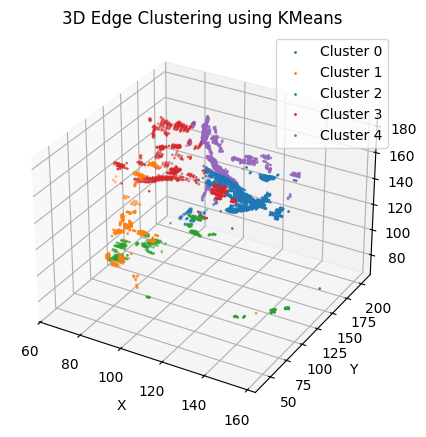

In [ ]:
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# edge map extraction
from scipy import ndimage
def sobel_edge_map(img_reg):
  img_ants = ants.image_read(img_reg)
  data = img_ants.numpy()
  spacing = img_ants.spacing

  sobel_x=ndimage.sobel(data,axis=0)
  sobel_y=ndimage.sobel(data,axis=1)
  sobel_z=ndimage.sobel(data,axis=2)
  edge_map=np.sqrt(sobel_x**2 +sobel_y**2 +sobel_z**2)
  edge_map_norm = (edge_map - edge_map.min()) / (edge_map.max() - edge_map.min() + 1e-8)
  edge_map_norm = np.nan_to_num(edge_map_norm, nan=0.0, posinf=0.0, neginf=0.0)
  ants_edge_img = ants.from_numpy(

      edge_map_norm,
      spacing=img_ants.spacing,
      origin=img_ants.origin,
      direction=img_ants.direction
    )
  edge_map_reg=os.path.splitext(img_reg)[0]+"_edge_map_"+os.path.splitext(img_reg)[1]
#thresholg selection

  threshold= np.percentile(edge_map_norm,99.98)
  #combined_mask=
  binary_edge = edge_map_norm > threshold
  edge_cord=np.column_stack(np.nonzero(binary_edge))
  edge_strength=edge_map_norm[binary_edge].reshape(-1,1)
  features=np.hstack((edge_cord,edge_strength))
# k-mean clustering
  kmeans=KMeans(n_clusters=5,n_init=20,random_state=1).fit(features)
  labels=kmeans.labels_
#highest kmean
  highest_intensity=[]
  edge_strength_flat=edge_strength.flatten()
  for i in range(5):
    mean = edge_strength[labels == i].mean()
    highest_intensity.append(mean)
  highest_kmean=np.argmax(highest_intensity)
  #print(highest_intensity[highest_kmean])
  for i, mean in enumerate(highest_intensity):
    print(f"Cluster {i}: Mean intensity = {mean:.4f}")

  print(f"\nCluster with highest mean intensity: {highest_kmean} (Mean = {highest_intensity[highest_kmean]:.4f})")

  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(111, projection='3d')

  for i in range(5):
      cluster_pts = edge_cord[labels == i]
      ax.scatter(cluster_pts[:, 2], cluster_pts[:, 1], cluster_pts[:, 0], s=1, label=f'Cluster {i}')  # x, y, z

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.legend()
  plt.title("3D Edge Clustering using KMeans")
  plt.show()

# Save as NIfTI
  ants.image_write(ants_edge_img,edge_map_reg)
img_reg="predicted_img.nii"
sobel_edge_map(img_reg)
#img_reg="/content/sub-patient19_cbf.nii"
#sobel_edge_map(img_reg)

In [ ]:
import matplotlib.pyplot as plt
import ants
import random
def plot_ants_slices(ants_img, title="Slice View"):
    data = ants_img.numpy()

    # Get center slice in each axis
    for i in range(random.randint(1,data.shape[0])):
      x_slice = data[i, :, :]
      y_slice = data[:, i, :]
      z_slice = data[:, :, i]

    # Plot slices
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(x_slice.T, cmap="inferno", origin="lower")
    axes[0].set_title('Axial Slice')

    axes[1].imshow(y_slice.T, cmap="inferno", origin="lower")
    axes[1].set_title('Coronal Slice')

    axes[2].imshow(z_slice.T, cmap="inferno", origin="lower")
    axes[2].set_title('Sagittal Slice')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


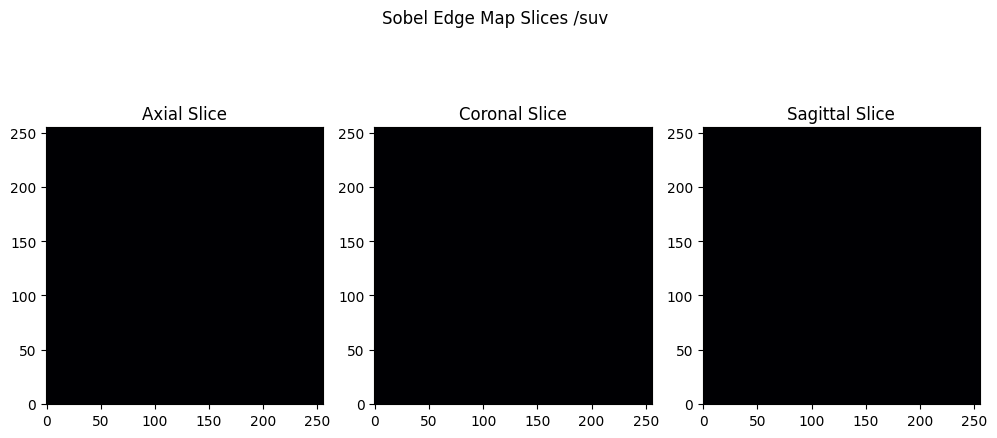

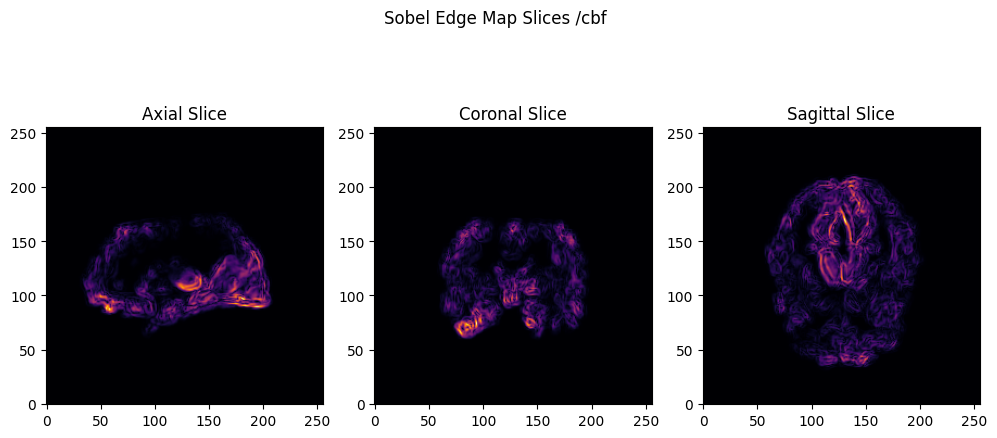

In [ ]:
edge_img1 = ants.image_read("/content/predicted_img.nii")
plot_ants_slices(edge_img1, title="Sobel Edge Map Slices /suv")
edge_img2 = ants.image_read("/content/predicted_img_edge_map_.nii")
plot_ants_slices(edge_img2, title="Sobel Edge Map Slices /cbf")


In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 15.4 MB/s eta 0:00:00


In [ ]:
import plotly.graph_objects as go
import ants
import numpy as np

# Read the image
img = ants.image_read("/content/compressed_img1.nii")
img_np = img.numpy()

# Squeeze if image is 4D
if img_np.ndim == 4:
    img_np = img_np.squeeze()

# Normalize
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

# Get shape
x = np.arange(img_np.shape[0])
y = np.arange(img_np.shape[1])
z = np.arange(img_np.shape[2])
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Create volume figure
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=img_np.flatten(),
    opacity=0.1,
    surface_count=20,
    colorscale='Inferno',
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(title="3D Medical Volume", width=700, height=700)

# 🔥 Save to file and manually open it
fig.write_html("volume4_plot.html")
print("✅ Plot saved as 'volume4plot.html'. Please open it in your browser.")


✅ Plot saved as 'volume4plot.html'. Please open it in your browser.


In [ ]:
ants.image_write(compressed_ants,"/content/compressed_img1.nii")